# Problem 1: Gillespie’s Direct Algorithm and Stochastic Hallmarks

### Event 1: Birth - $X -> X + 1$
- Rate  1: $\mu N$

### Event 2: Transmission - $Y -> Y + 1$ & $X -> X - 1$
- Rate  2: $\beta{XY \over N}$

### Event 3: Recovery - $Y -> Y - 1$
- Rate 3: $\gamma Y$

### Event 4: Natural Death - $N -> N - 1$
Split up into two parts in order to preserve constant population. The used timestep is determined from the rate
of Event 4, while the sub-event to execute is chosen based on the smallest timestep from the possible sub-events
but which is not added to the cumulative time. 

- rate 4: $\mu N$

#### Sub-event 4.1: Susceptible death - $X -> X - 1$
- rate 4.1: $\mu X$
#### Sub-event 4.2: Infected death - $Y -> Y - 1$
- rate 4.2: $\mu Y$
#### Sub-event 4.3: Recovered death - $Z -> Z - 1$
- rate 4.3: $\mu Z$



In [6]:
from typing import List, Tuple

from math   import log, inf, isinf
from random import random

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

%matplotlib widget


class Gillespie:
    BIRTH        = 0
    TRANSMISSION = 1
    RECOVERY     = 2
    DEATH_SUS    = 3
    DEATH_INF    = 4
    DEATH_RES    = 5
    DEATH_GEN    = 6

    def __init__(self, beta: float, gamma: float, mu: float, nSusceptible: int, nInfected: int, nResistent: int) -> None:
        self._beta  = beta
        self._gamma = gamma
        self._mu    = mu

        self._nSus = nSusceptible
        self._nInf = nInfected
        self._nRes = nResistent

        self._nPop = nSusceptible + nInfected + nResistent

        self._time = 0.0
    
    def seedInfection(self, nPop = 1) -> int:
        """
        Infect a portion of the susceptible population

        Args:
            nPop: population to infect (Default: 1)
        
        Returns (int):
            The amount of Susceptibles infected.
        """
        if nPop > self._nSus:
            nPop = self._nSus

        self._nInf += nPop
        self._nSus -= nPop

        return nPop

    def get_rateBirth(self) -> float:
        """Returns the rate of birth for the current population"""
        return self._mu * self._nPop
    
    def get_rateTransmission(self) -> float:
        """Return the rate of transmission for the current population"""
        return self._beta * ((self._nSus * self._nInf) / self._nPop)
    
    def get_rateRecovery(self) -> float:
        """Returns the rate of recovery for the current population"""
        return self._gamma * self._nInf
    
    def get_rateDeathGen(self) -> float:
        return self._mu * self._nPop

    def get_rateDeathSus(self) -> float:
        return (self._mu * self._nSus)
    
    def get_rateDeathInf(self) -> float:
        return (self._mu * self._nInf)
    
    def get_rateDeathRes(self) -> float:
        return (self._mu * self._nRes)
    
    def get_rates(self) -> List[Tuple[int, float]]:
        return [
                (self.BIRTH,        self.get_rateBirth()       ), 
                (self.TRANSMISSION, self.get_rateTransmission()), 
                (self.RECOVERY,     self.get_rateRecovery()    ), 
                (self.DEATH_GEN,    self.get_rateDeathGen()    )
            ]
    
    def get_deatRates(self) -> List[Tuple[int, float]]:
        return [
            (self.DEATH_SUS, self.get_rateDeathSus()),
            (self.DEATH_INF, self.get_rateDeathInf()),
            (self.DEATH_RES, self.get_rateDeathRes())
        ]
    
    def calcRandomDeltaT(self, rate: float) -> float:
        if rate <= 0: 
            return inf
        return -1 / (rate * log(random()))
    
    def updatePopulations(self, event: int) -> None:
        match event:
            case self.BIRTH:
                self._nSus += 1

                self._nPop += 1

            case self.TRANSMISSION:
                self._nSus -= 1
                self._nInf += 1

            case self.RECOVERY:
                self._nInf -= 1
                self._nRes += 1

            case self.DEATH_SUS:
                self._nSus -= 1

                self._nPop -= 1

            case self.DEATH_INF:
                self._nInf -= 1

                self._nPop -= 1
            
            case self.DEATH_RES:
                self._nRes -= 1

                self._nPop -= 1

    def propagateModel(self) -> int:
        minDelta: float = -1

        for event, rate in self.get_rates():
            newDelta = self.calcRandomDeltaT(rate)
        
            if (newDelta < minDelta) or minDelta == -1:
                minDelta = newDelta
                nextEvent = event
        
        if nextEvent == self.DEATH_GEN:
            deathDelta: float = -1
            for event, rate in self.get_deatRates():
                newDelta = self.calcRandomDeltaT(rate)
        
                if (newDelta < deathDelta) or deathDelta == -1:
                    deathDelta = newDelta
                    # Change deltaT into trhe chance an individual of this group dies
                    # minDelta = newDelta
                    nextEvent = event

        self.updatePopulations(nextEvent)
        self._time += minDelta

        return minDelta

    def get_plotPoints(self) -> Tuple[float, int, int, int, int]:
        return self._time, self._nSus, self._nInf, self._nRes, self._nPop

def runTimedGillespie(model: Gillespie, tmax = 100) -> List[Tuple[float, int, int, int, int]]:
    outData = [model.get_plotPoints()]
    time = outData[-1][0]
    checkin = 10

    while time < tmax:
        if outData[-1][-1] == 0:
            break
        model.propagateModel()
        outData.append(model.get_plotPoints())
    
        time, _, inf, _, pop = outData[-1]
    return outData

def plotGillespieData(inData: List[Tuple[float, int, int, int, int]]):
    fig, ax = plt.subplots()

    assert(isinstance(ax, plt.Axes))
    
    times        = [time for time, sus, inf, res, pop in inData]
    susceptibles = [sus  for time, sus, inf, res, pop in inData]
    infecteds    = [inf  for time, sus, inf, res, pop in inData]
    resistants   = [res  for time, sus, inf, res, pop in inData]
    populations  = [pop  for time, sus, inf, res, pop in inData]

    ax.plot(times, susceptibles, label="Susceptible pop.")
    ax.plot(times, infecteds,    label="Infected pop.")
    ax.plot(times, resistants,   label="Resistant pop.")
    ax.plot(times, populations,  label="Total Pop.")

    ax.legend()


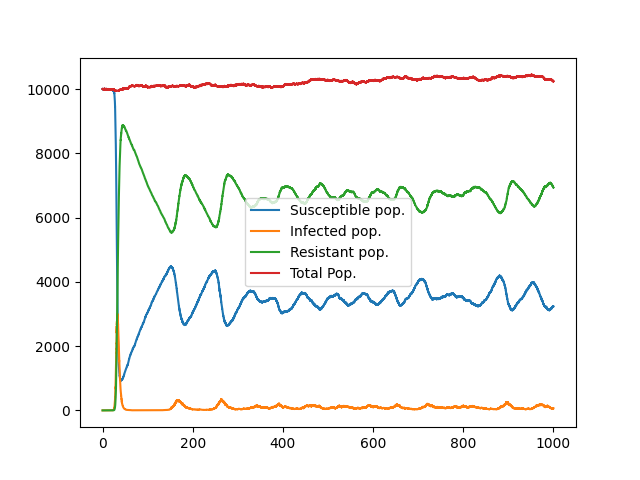

In [151]:
model = Gillespie(3, 1, 1/80, 10000, 0, 0)
model.seedInfection(1)

data = runTimedGillespie(model, 1000)

plotGillespieData(data)

# Problem 2: Spatial Models - Networks
assess the spread of a disease (SIR) across different types of model networks (Barabasi Albert,
Watts-Strogatz, Erdos-Reyni).

Barabasi Albert graph parameters:
- Amount of nodes $n$
- Amount of edges per new node $m$, with preffered atachment to high degre nodes
    - Uniform sampling from [node for node, degree in graph.degree() for _ in range(degree)]
    - eg. a node with degree 1 is only present once, while a node with degree 2 is present twice.

- probability a new node is connected to node $i$ with $k_{i}$ edges[^1]
$$p_{i} = {k_{i} \over \sum_{j} k_{j}}$$

[^1]: https://en.wikipedia.org/wiki/Barab%C3%A1si%E2%80%93Albert_model

Watts-Strogatz:
- amount of nodes $n$
- Amount of joined neighbors $k$
- Probability of rewiring $p$


Erdos-Reyni graph parameters:
- amount of nodes n (duh)
- Edge creation probability p

expected edges per node
$$E = np$$ 


importing Network data:
- Load CSV file
- Import weighted graph
    - store first line as "register" of nodes
    - incrementally load more edges for everyline in file

In [88]:
import networkx as nx
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc
import matplotlib.pyplot as plt

from copy import deepcopy

from typing import Tuple, List, Dict

%matplotlib widget

# Horizontal nodes
# nodeRegister = [int(item) for item in file.readline().split(';')[1:]]

# for line, iter in zip(file, range(file.lines))
#   splitLine = [int(item) for item in line.split(';')]
#   currentNode = splitLine[0]
#   splitLine = splitLine[1:]
#
#   

# edges = 0, 1, 2, 3, ..., L-1

def runNetworkSir(network: nx.Graph, beta: float, gamma: float, fractionInfected: float = 0.05, iterations = 1000) -> List[Dict]:
    model = ep.SIRModel(network)
    
    config = mc.Configuration()
    config.add_model_parameter('beta', beta)
    config.add_model_parameter('gamma', gamma)
    config.add_model_parameter("fraction_infected", fractionInfected)
    model.set_initial_status(config)

    outData = []
    for iter in range(iterations):
        outData.append(model.iteration())
    
    return outData


def plotNetSIRdata(inData: List[Dict[str, Dict[int, int]]]) -> Tuple[plt.Figure, plt.Axes]:
    iterations   = list(range(len(inData)))
    
    nPop = inData[0]["node_count"][0] + inData[0]["node_count"][1] + inData[0]["node_count"][2]

    susceptibles = [item["node_count"][0] / nPop for item in inData]
    infecteds    = [item["node_count"][1] / nPop for item in inData]
    recovereds   = [item["node_count"][2] / nPop for item in inData]

    fig, ax = plt.subplots()
    assert(isinstance(ax, plt.Axes))

    ax.plot(iterations, susceptibles, label="Susceptible Fraction")
    ax.plot(iterations, infecteds,    label="infected Fraction"   )
    ax.plot(iterations, recovereds,   label="Recovered Fraction"  )

    return fig, ax


def plotEdgeDist(graph: nx.Graph) -> Tuple[plt.Figure, plt.Axes]:
    degrees = [degree for node, degree in graph.degree()]

    bins = range(min(degrees), max(degrees) + 1, 1)
    fig, ax = plt.subplots()
    
    assert(isinstance(ax, plt.Axes))

    ax.hist(degrees, bins, density=True)

    return fig, ax


def loadNetwork(filename: str) -> nx.Graph:
    network = nx.Graph()

    with open(filename) as csvFile:
        # First line contains a list of all nodes in the system
        nodeRegister = [int(item) for item in csvFile.readline().split(';')[1:]]

        lineNum = 0

        for line in csvFile:
            nodeConnections = [int(item) for item in line.split(';')]
            nodeA = nodeConnections[0]

            network.add_node(nodeA)

            for nodeB, weight in zip(nodeRegister[:lineNum], nodeConnections[1:]):
                # print(f"A: {nodeA}, B:{nodeB}, W:{weight}")
                if weight:
                    network.add_edge(nodeA, nodeB)
            
            lineNum += 1
    
    return network

(<Figure size 640x480 with 1 Axes>, <Axes: >)

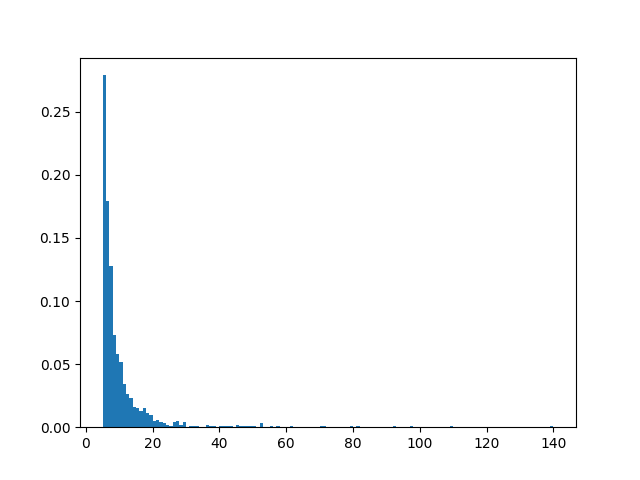

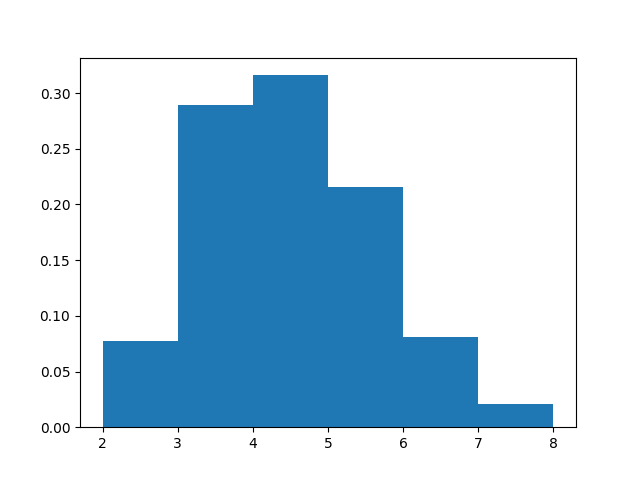

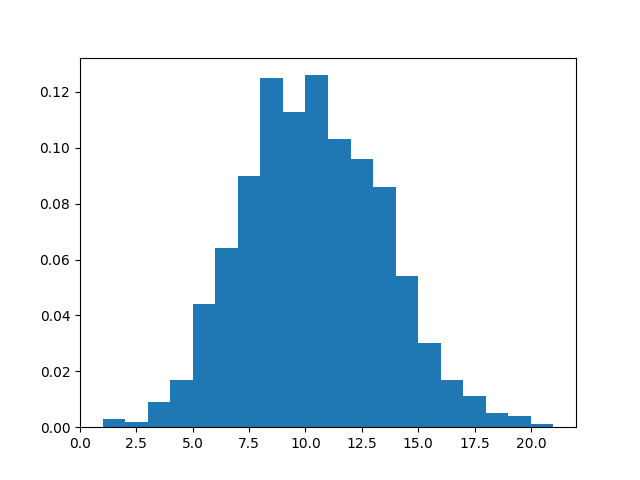

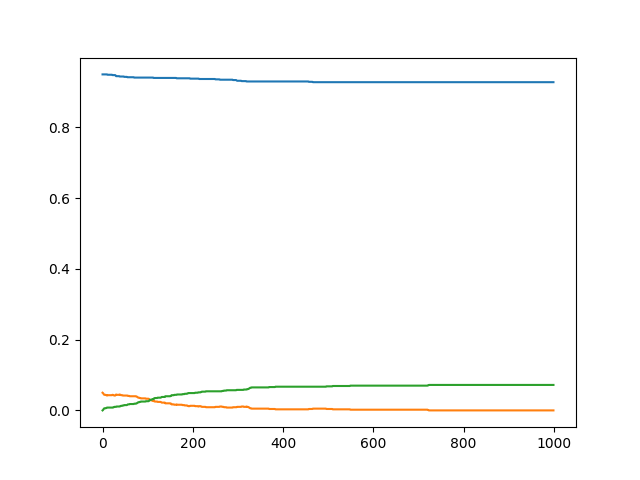

In [89]:
network = nx.barabasi_albert_graph(1000, 5)
plotEdgeDist(network)

network = nx.watts_strogatz_graph(1000, 4, 0.5)
plotEdgeDist(network)

network = nx.erdos_renyi_graph(1000, 0.01)

plotEdgeDist(network)

outData = runNetworkSir(network, beta= 0.0003, gamma = 0.01)

plotNetSIRdata(outData)



In [67]:
# load transmission network
transmission_network = loadNetwork("data/transmission_network.csv")

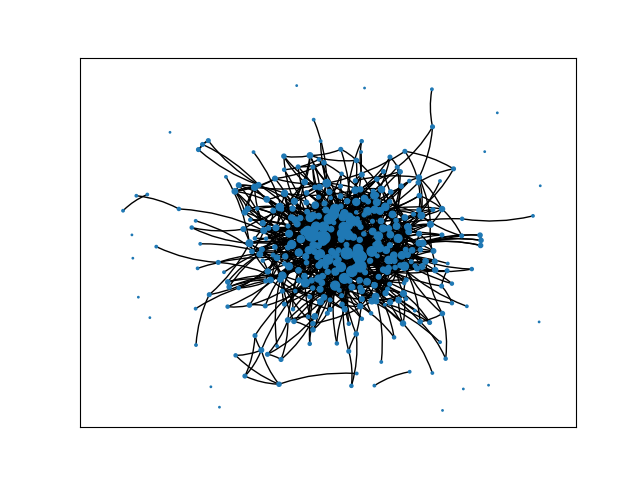

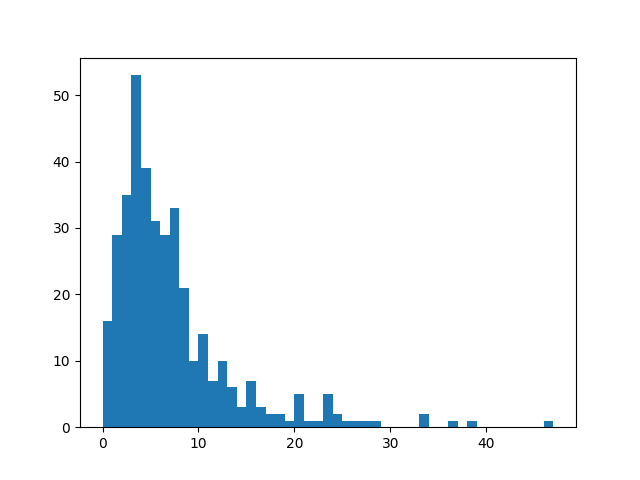

In [73]:
# testing network import
fig, ax = plt.subplots()
graph = deepcopy(transmission_network)

plotEdgeDist(graph)

d = dict(graph.degree)

pos = nx.spring_layout(graph,  2/10, weight="degree")
nx.draw_networkx(graph, pos=pos, arrows=True, with_labels=False, ax=ax,node_size=[1 + v * 2 for v in d.values()], connectionstyle="arc3,rad=0.1")
